In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install fastai

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/JanathaHack/train_SOaYf6m.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['train.csv', 'images', 'sample_submission_yxjOnvz.csv', 'test_vc2kHdQ.csv']


In [ ]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [ ]:
data_folder = Path("input/")

In [ ]:
data_path = "input/images/"
path = os.path.join(data_path , "*jpg")

In [ ]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test_vc2kHdQ.csv')
submit = pd.read_csv('input/sample_submission_yxjOnvz.csv')

In [ ]:
train_imagesdf=[]
for file1 in train_df["image_names"].values:
      image = cv2.imread("input/images/"+file1)
      train_imagesdf.append(image)
test_imagesdf=[]
for file1 in test_df["image_names"].values:
      image = cv2.imread("input/images/"+file1)
      test_imagesdf.append(image)

In [ ]:
train_df.shape, test_df.shape

((1646, 2), (706, 1))

In [ ]:
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [ ]:
test_df.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [ ]:
train_df.groupby('emergency_or_not').count()

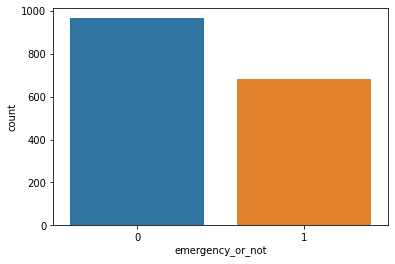

In [ ]:
sns.countplot(x='emergency_or_not' , data=train_df)

In [ ]:
train_images = train_imagesdf
test_images= test_imagesdf

In [ ]:
category = {'Emegerncy': 1, 
'Not_Emegerncy': 0}

In [ ]:
def plot_class(cat):
    
    fetch = train_df.loc[train_df['emergency_or_not']== category[cat]][:3]
    fig = plt.figure(figsize=(20,15))
    
    for i , index in enumerate(fetch.index ,1):
        plt.subplot(1,3 ,i)
        plt.imshow(train_images[index])
        plt.xlabel(cat + " (Index:" +str(index)+")" )
    plt.show()

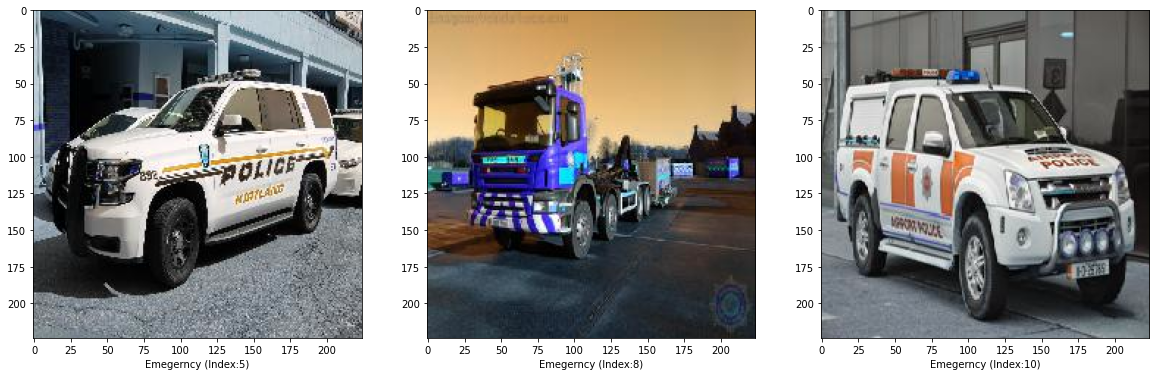

In [ ]:
plot_class('Emegerncy')

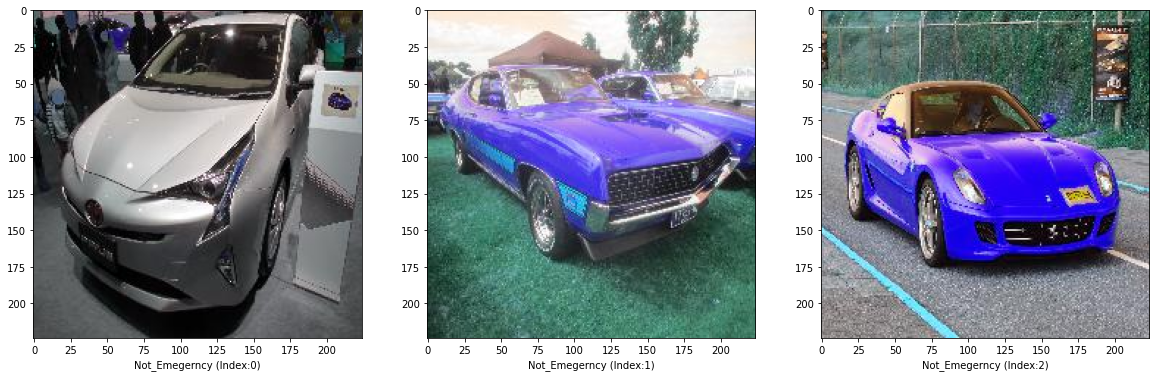

In [ ]:
plot_class('Not_Emegerncy')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))

## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path=data_folder, folder='images')

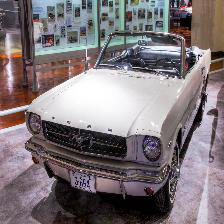

In [ ]:
test_img[0]

In [ ]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path=data_folder, folder='images')
       .split_by_rand_pct(0.2)
      #  .split_none()
       .label_from_df()
       .add_test(test_img))

In [ ]:
src

LabelLists;

Train: LabelList (1317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,1
Path: input;

Valid: LabelList (329 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,0
Path: input;

Test: LabelList (706 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: input

In [ ]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=64,device= torch.device('cuda:0')).normalize(imagenet_stats))

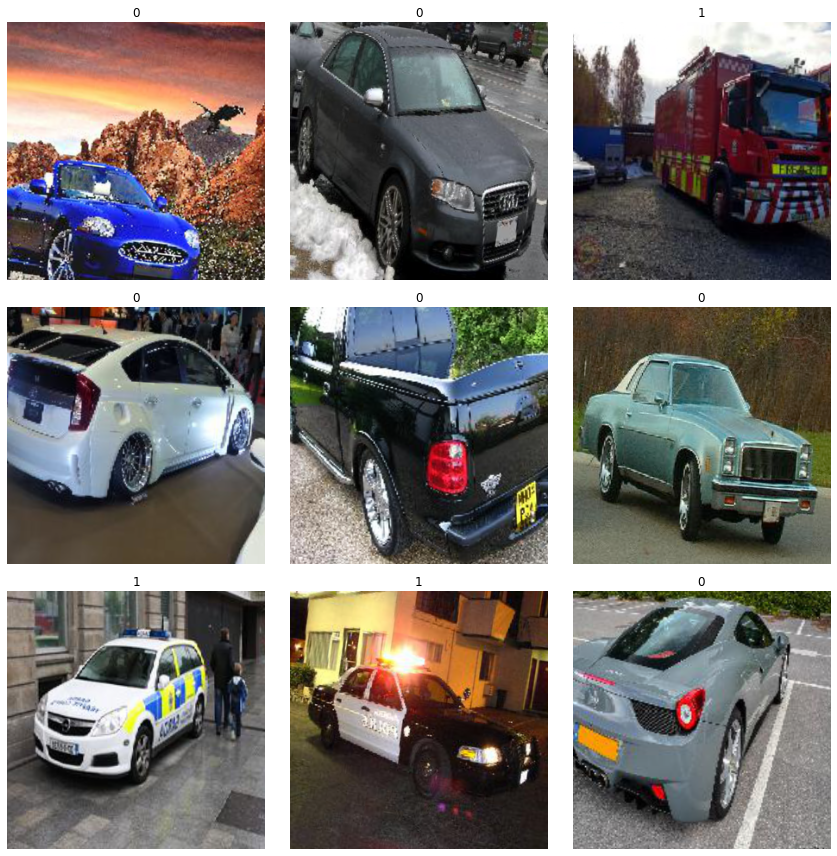

In [ ]:
data.show_batch(rows=3, figsize=(12,12))

In [ ]:
print(data.classes)

[0, 1]


In [ ]:
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 5.75E-03


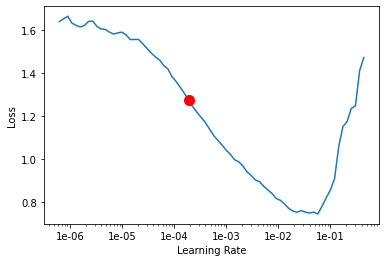

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.152899,0.414944,0.827361,0.829787,00:18
1,0.744555,0.240315,0.906193,0.908815,00:18
2,0.526355,0.203806,0.933144,0.936170,00:18
3,0.405105,0.212159,0.933494,0.936170,00:18
4,0.310394,0.214112,0.936580,0.939210,00:18
5,0.264026,0.217703,0.942616,0.945289,00:18
6,0.223527,0.204250,0.942772,0.945289,00:18
7,0.186032,0.231338,0.936240,0.939210,00:18
8,0.153510,0.212371,0.936413,0.939210,00:18
9,0.129419,0.199229,0.939828,0.942249,00:18


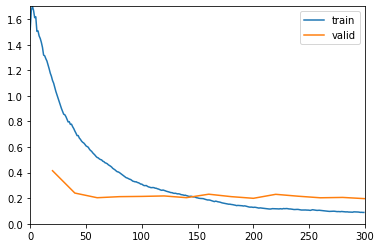

In [ ]:
lr = 3e-04
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(15, slice(lr), wd=0.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.58E-07


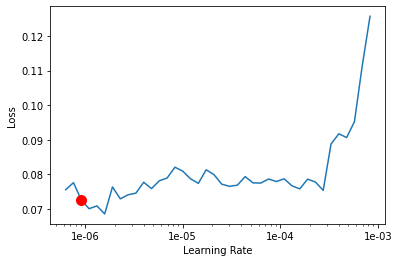

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.077377,0.203598,0.952373,0.954407,00:23
1,0.070080,0.182796,0.949264,0.951368,00:23
2,0.059822,0.186130,0.949130,0.951368,00:23
3,0.069377,0.174601,0.952496,0.954407,00:23
4,0.070327,0.169134,0.949517,0.951368,00:22
5,0.059981,0.157407,0.962137,0.963526,00:23
6,0.054215,0.165115,0.962044,0.963526,00:23
7,0.040045,0.163359,0.962044,0.963526,00:23
8,0.038897,0.167730,0.955606,0.957447,00:22
9,0.036765,0.170995,0.958829,0.960486,00:23


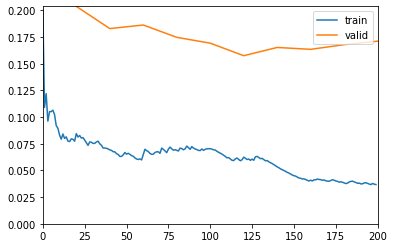

In [ ]:
learn.fit_one_cycle(10,slice(1e-05,lr/8),wd=0.15)

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time


RuntimeError: ignored

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.019892,0.176327,0.952496,0.954407,00:16
1,0.017196,0.187233,0.958829,0.960486,00:16
2,0.013268,0.182517,0.955718,0.957447,00:16
3,0.015095,0.174923,0.955718,0.957447,00:16
4,0.015549,0.175365,0.952614,0.954407,00:16
5,0.013912,0.178333,0.949392,0.951368,00:16


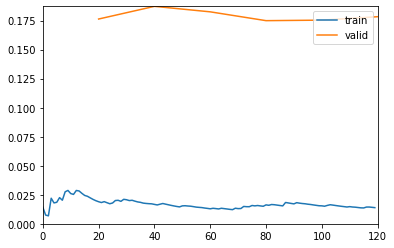

In [ ]:
learn.fit_one_cycle(6, slice(1.1e-06, lr/10),wd=0.1)

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(6, slice(4e-07, lr/20),wd=0.1)

epoch,train_loss,valid_loss,f_beta,accuracy,time


RuntimeError: ignored

In [ ]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.014983,0.202553,0.965334,0.966565,00:47
1,0.013094,0.198812,0.965334,0.966565,00:47
2,0.015565,0.201992,0.962137,0.963526,00:47
3,0.017525,0.197177,0.962227,0.963526,00:47
4,0.014969,0.195130,0.962227,0.963526,00:47


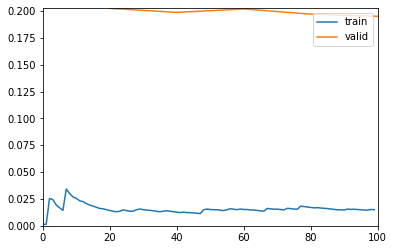

In [ ]:
learn.fit_one_cycle(5, slice(5e-07, lr/20),wd=0.1)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.005036,0.180168,0.962137,0.963526,00:18
1,0.008676,0.175676,0.962137,0.963526,00:19
2,0.007782,0.171724,0.965334,0.966565,00:19
3,0.008600,0.167103,0.965334,0.966565,00:19
4,0.008219,0.168360,0.965334,0.966565,00:18
5,0.007756,0.176110,0.965334,0.966565,00:18


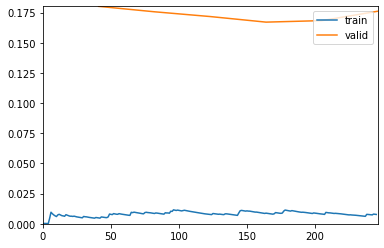

In [ ]:
learn.fit_one_cycle(6, slice(1e-07, lr/100))

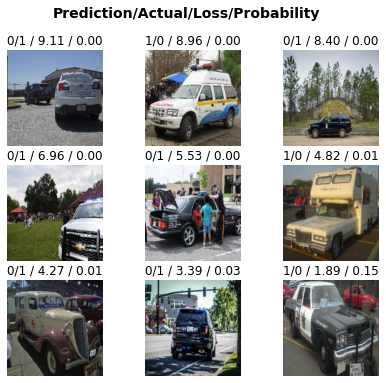

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,6))

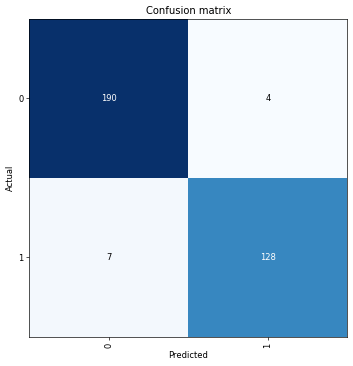

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60) ## on validation set

In [ ]:
interp.most_confused(min_val=4) ## on validation set

[(1, 0, 9)]

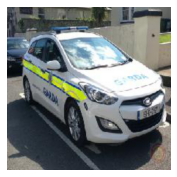

In [ ]:
idx=2
x,y = data.valid_ds[idx]
x.show()

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
t = data.valid_ds[1][0].data; t.shape

torch.Size([3, 299, 299])

In [ ]:
edge = F.conv2d(t[None], k)

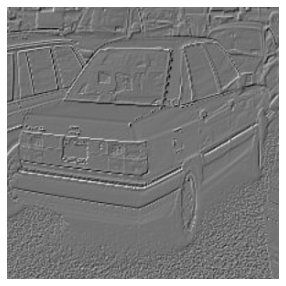

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 10, 10])

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape
torch.Size([11, 11])

torch.Size([11, 11])

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

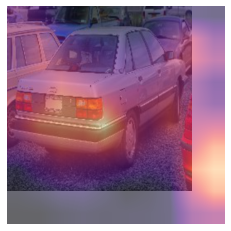

In [ ]:
show_heatmap(avg_acts)


In [ ]:
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
# preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [ ]:
df = pd.DataFrame({'image_names':test_df['image_names'], 'emergency_or_not':labelled_preds}, columns=['image_names', 'emergency_or_not'])
# df["emergency_or_not"] = df["emergency_or_not"]
df.to_csv('submission3.csv', index=False)